In [50]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import statistics as st
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import classification_report

#import sys
#!{sys.executable} -m pip install keras-rectified-adam

# Import custom functions
from preprocessing import *
from evaluation import *
from model import *

In [17]:
# List of training, validation, and test X_files
X_files = ['TrainingData/subject_001_01__x.csv', 'TrainingData/subject_001_02__x.csv', 
           'TrainingData/subject_001_03__x.csv', 'TrainingData/subject_001_04__x.csv', 
           'TrainingData/subject_001_05__x.csv', 'TrainingData/subject_001_06__x.csv', 
           'TrainingData/subject_001_07__x.csv', 'TrainingData/subject_002_02__x.csv', 
           'TrainingData/subject_002_03__x.csv', 'TrainingData/subject_002_04__x.csv', 
           'TrainingData/subject_002_05__x.csv', 'TrainingData/subject_003_01__x.csv', 
           'TrainingData/subject_003_02__x.csv', 'TrainingData/subject_003_03__x.csv', 
           'TrainingData/subject_004_01__x.csv', 'TrainingData/subject_004_02__x.csv', 
           'TrainingData/subject_005_01__x.csv', 'TrainingData/subject_005_02__x.csv', 
           'TrainingData/subject_005_03__x.csv', 'TrainingData/subject_006_01__x.csv', 
           'TrainingData/subject_006_02__x.csv', 'TrainingData/subject_007_02__x.csv', 
           'TrainingData/subject_007_03__x.csv', 'TrainingData/subject_007_04__x.csv',
           'TrainingData/subject_008_01__x.csv']

val_X_files = ['TrainingData/subject_002_01__x.csv', 'TrainingData/subject_001_08__x.csv']
test_X_files = ['TrainingData/subject_006_03__x.csv', 'TrainingData/subject_007_01__x.csv']

# List of training, validation, and test y_files
y_files = ['TrainingData/subject_001_01__y.csv', 'TrainingData/subject_001_02__y.csv', 
           'TrainingData/subject_001_03__y.csv', 'TrainingData/subject_001_04__y.csv', 
           'TrainingData/subject_001_05__y.csv', 'TrainingData/subject_001_06__y.csv', 
           'TrainingData/subject_001_07__y.csv', 'TrainingData/subject_002_02__y.csv',
           'TrainingData/subject_002_03__y.csv', 'TrainingData/subject_002_04__y.csv', 
           'TrainingData/subject_002_05__y.csv', 'TrainingData/subject_003_01__y.csv', 
           'TrainingData/subject_003_02__y.csv', 'TrainingData/subject_003_03__y.csv', 
           'TrainingData/subject_004_01__y.csv', 'TrainingData/subject_004_02__y.csv', 
           'TrainingData/subject_005_01__y.csv', 'TrainingData/subject_005_02__y.csv', 
           'TrainingData/subject_005_03__y.csv', 'TrainingData/subject_006_01__y.csv', 
           'TrainingData/subject_006_02__y.csv', 'TrainingData/subject_007_02__y.csv', 
           'TrainingData/subject_007_03__y.csv', 'TrainingData/subject_007_04__y.csv',
           'TrainingData/subject_008_01__y.csv']

val_y_files = ['TrainingData/subject_002_01__y.csv', 'TrainingData/subject_001_08__y.csv']
test_y_files = ['TrainingData/subject_006_03__y.csv', 'TrainingData/subject_007_01__y.csv']

In [18]:
training_X, training_y = create_time_series_data(X_files, y_files, 30, 1)
val_X, val_y = create_time_series_data(val_X_files, val_y_files, 30, 1)
test_X, test_y = create_time_series_data(test_X_files, test_y_files, 30, 1)

print(training_X.shape, training_y.shape)
print(val_X.shape, val_y.shape)
print(test_X.shape, test_y.shape)

(1126710, 30, 6) (1126710, 1)
(122696, 30, 6) (122696, 1)
(91260, 30, 6) (91260, 1)


In [21]:
# Save the training data to .npy files so we do not have to generate them repeatedly
np.save('processed_data/training_X.npy', training_X)
np.save('processed_data/training_y.npy', training_y)
np.save('processed_data/val_X.npy', val_X)
np.save('processed_data/val_y.npy', val_y)
np.save('processed_data/test_X.npy', test_X)
np.save('processed_data/test_y.npy', test_y)

In [22]:
# Loading the data back
training_X = np.load('processed_data/training_X.npy')
training_y = np.load('processed_data/training_y.npy')
val_X = np.load('processed_data/val_X.npy')
val_y = np.load('processed_data/val_y.npy')
test_X = np.load('processed_data/test_X.npy')
test_y = np.load('processed_data/test_y.npy')

In [24]:
# Get training label weights
label_weights = get_label_weights(training_X, training_y)
print(label_weights)

# Perform one-hot encoding on all labels
training_y_encoded = one_hot_encoding(training_y)
val_y_encoded = one_hot_encoding(val_y)
test_y_encoded = one_hot_encoding(test_y)
print(training_y_encoded.shape, val_y_encoded.shape, test_y_encoded.shape)

/usr/local/Cellar/jupyterlab/3.0.9/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 0.3258715475333822, 1: 5.860711164745537, 2: 4.427916810764926, 3: 1.8697229376310969}
(1126710, 4) (122696, 4) (91260, 4)


In [39]:
model = define_BiLSTM_model(training_X, training_y_encoded)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 250)               132000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 125)               31375     
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 504       
Total params: 163,879
Trainable params: 163,879
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit(training_X, training_y_encoded, epochs = 10, batch_size = 64,
                   validation_data = (val_X, val_y_encoded), class_weight = label_weights,
                   verbose = 1, shuffle = True)

Train on 1126710 samples, validate on 122696 samples
Epoch 1/10
1126710/1126710 [==============================] - 1340s 1ms/step - loss: 0.2001 - acc: 0.8831 - f1: 0.8800 - precision_measure: 0.8885 - recall_measure: 0.8727 - val_loss: 1.3778 - val_acc: 0.5955 - val_f1: 0.5921 - val_precision_measure: 0.5978 - val_recall_measure: 0.5870
Epoch 2/10
1126710/1126710 [==============================] - 1324s 1ms/step - loss: 0.0983 - acc: 0.9376 - f1: 0.9374 - precision_measure: 0.9398 - recall_measure: 0.9351 - val_loss: 1.6107 - val_acc: 0.6043 - val_f1: 0.6018 - val_precision_measure: 0.6049 - val_recall_measure: 0.5990
Epoch 3/10
1126710/1126710 [==============================] - 1284s 1ms/step - loss: 0.0691 - acc: 0.9541 - f1: 0.9540 - precision_measure: 0.9551 - recall_measure: 0.9530 - val_loss: 2.0734 - val_acc: 0.5978 - val_f1: 0.5960 - val_precision_measure: 0.5985 - val_recall_measure: 0.5936
Epoch 4/10
1126710/1126710 [==============================] - 1229s 1ms/step - loss: 0

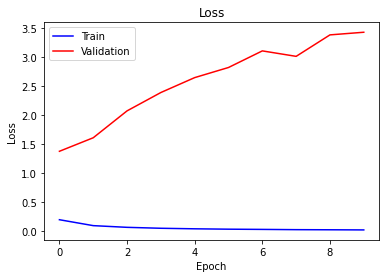

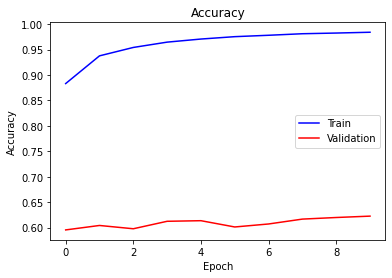

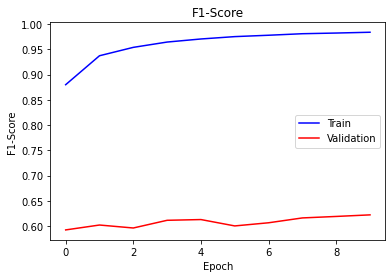

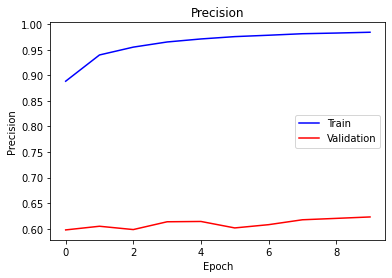

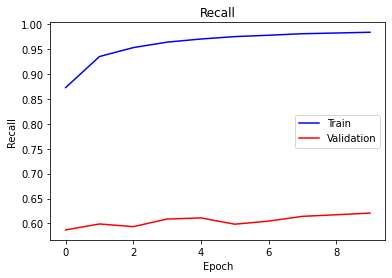

In [49]:
plot_history(history)

In [42]:
model.evaluate(test_X, test_y_encoded)

91260/91260 [==============================] - 43s 470us/step


[0.3247964921183148,
 0.9340236686390533,
 0.9339926425365145,
 0.9342043334288789,
 0.9337935568704799]

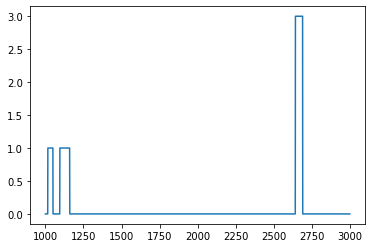

In [58]:
# Comparing actual versus predicted in a plot on our test set
actual_data = pd.read_csv('TrainingData/subject_006_03__y.csv')
plt.plot(actual_data.iloc[1000:3000])

91260/91260 [==============================] - 25s 279us/step
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     65623
           1       0.84      0.97      0.90      2892
           2       0.91      0.99      0.95      3745
           3       0.91      0.81      0.86     19000

    accuracy                           0.93     91260
   macro avg       0.90      0.93      0.92     91260
weighted avg       0.93      0.93      0.93     91260



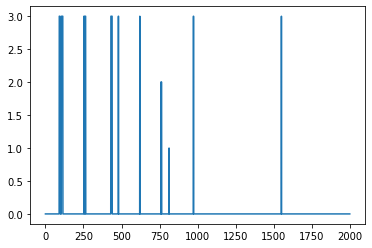

In [59]:
predicted_data = model.predict(test_X, batch_size = 64, verbose = 1)
y_test_bool = np.argmax(predicted_data, axis = 1)
print(classification_report(test_y, y_test_bool))
plt.plot(y_test_bool[1000:3000])

In [44]:
# Get predictions using test data
test_files = ['TestData/subject_009_01__x.csv', 'TestData/subject_010_01__x.csv', 
              'TestData/subject_011_01__x.csv', 'TestData/subject_012_01__x.csv']

y_files = ['TestData/subject_009_01__y_time.csv', 'TestData/subject_010_01__y_time.csv',
           'TestData/subject_011_01__y_time.csv', 'TestData/subject_012_01__y_time.csv']

prediction_files = ['subject_009_01__y_prediction.csv', 'subject_010_01__y_prediction.csv',
                    'subject_011_01__y_prediction.csv', 'subject_012_01__y_prediction.csv']

In [46]:
for i in range(len(test_files)):
    input_data = pd.read_csv(test_files[i])
    df = scale_data(input_data, list(input_data.columns.values))
    y_frame = pd.read_csv(y_files[i])
    addl = y_frame.shape[0] * 4 - df.shape[0] + 30
    addl_df = pd.DataFrame(df.iloc[-addl:])
    df = df.append(addl_df)
    X_test = create_dataset(df, 30, 1)
    y_test = model.predict(X_test, batch_size = 64, verbose = 1)
    y_test_bool = np.argmax(y_test, axis = 1)
    y_actual = get_majority(y_test_bool)
    print(y_actual.size)
    y_series = pd.Series(y_actual)
    y_series.to_csv("C2_predictions/" + prediction_files[i])

37988/37988 [==============================] - 27s 719us/step
9497
49076/49076 [==============================] - 34s 688us/step
12269
51756/51756 [==============================] - 22s 431us/step
12939
45316/45316 [==============================] - 39s 863us/step
11329



# Final F1-score on hidden test data is 0.8602899935107109